In [5]:
import numpy as np
import pickle
import torch
from torch import nn
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import math
import re
import torch.optim as optim
from scipy.stats import spearmanr
from sklearn.metrics import jaccard_score

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Spearman correlation for first-variants' improved fitness

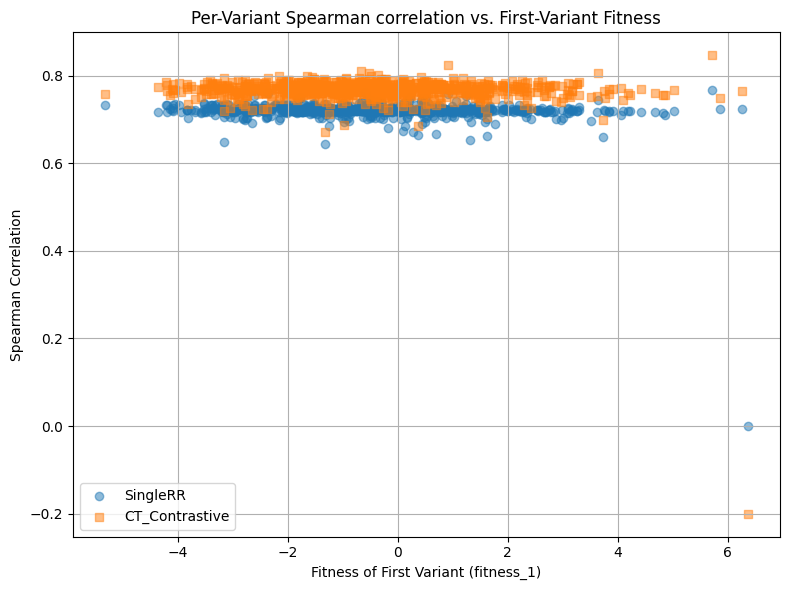

In [3]:
# create a mapping from round 3 test set sequences to SingleRR predicted fitness

test_df = pd.read_csv('/content/drive/MyDrive/Mid_1_data_train/data_single_test_r3.csv')
results_SingleRR = pickle.load(open("/content/drive/MyDrive/Mid_1_RR_results/single_final_predictions.pkl", "rb"))["preds"]
seq2fit_SingleRR = dict(zip(test_df['seq'], results_SingleRR))


# retrieve Contrastive model pred
df_te = pd.read_csv('/content/drive/MyDrive/Mid_1_data_train/data_contrastive_test_r3.csv')
best_preds = pickle.load(open(f"/content/drive/MyDrive/Mid_1_Contrast_results/CT_Contrastive_preds.pkl", "rb"))['preds'][-len(df_te):]
df_te['Contrast_pred'] = best_preds


# SingleRR pairwise diff predictions with only second variant fitness predicted
df_te['SingleRR_pred'] = df_te.apply(
    lambda row: seq2fit_SingleRR[row['seq_2']] - row['fitness_1'],
    axis=1
)

'''
# SingleRR pairwise diff predictions with both fitness predicted
df_te['SingleRR_pred'] = df_te.apply(
    lambda row: seq2fit_SingleRR[row['seq_2']] - seq2fit_SingleRR[row['seq_1']],
    axis=1
)
'''

# 2) For Each Unique seq_1, Compute Spearman Correlations
fitness_list       = []
spearman_single    = []
spearman_contrast  = []

grouped = df_te.groupby('seq_1', sort=False)

for seq1, group in grouped:
    # the fitness_1 is constant within the group
    fitness = group['fitness_1'].iloc[0]
    labels        = group['label'].values
    single_preds  = group['SingleRR_pred'].values
    contrast_preds= group['Contrast_pred'].values

    # Only compute Spearman if there are ≥ 2 samples
    if len(labels) <= 1:
        continue
    corr_s, _ = spearmanr(labels, single_preds)
    corr_c, _ = spearmanr(labels, contrast_preds)

    fitness_list.append(fitness)
    spearman_single.append(corr_s)
    spearman_contrast.append(corr_c)

# 3) Sort by Fitness so the plot is nice
fitness_arr      = np.array(fitness_list)
order            = np.argsort(fitness_arr)
fitness_sorted   = fitness_arr[order]
spearman_single_sorted   = np.array(spearman_single)[order]
spearman_contrast_sorted = np.array(spearman_contrast)[order]

# 4) Plot
plt.figure(figsize=(8,6))
plt.scatter(fitness_sorted, spearman_single_sorted, marker='o', alpha=0.5, label='SingleRR')
plt.scatter(fitness_sorted, spearman_contrast_sorted, marker='s', alpha=0.5, label='CT_Contrastive')
plt.xlabel("Fitness of First Variant (fitness_1)")
plt.ylabel("Spearman Correlation")
plt.title("Per-Variant Spearman correlation vs. First-Variant Fitness")
plt.legend()
plt.grid(True)
plt.tight_layout()

# Save figure
out_path = "/content/drive/MyDrive/Mid_1_RR_results/spearman_vs_fitness_diff_comparison.png"
plt.savefig(out_path)
plt.show()


# Top 10 first variants' Jaccard Index --- ground truth vs SingleRR

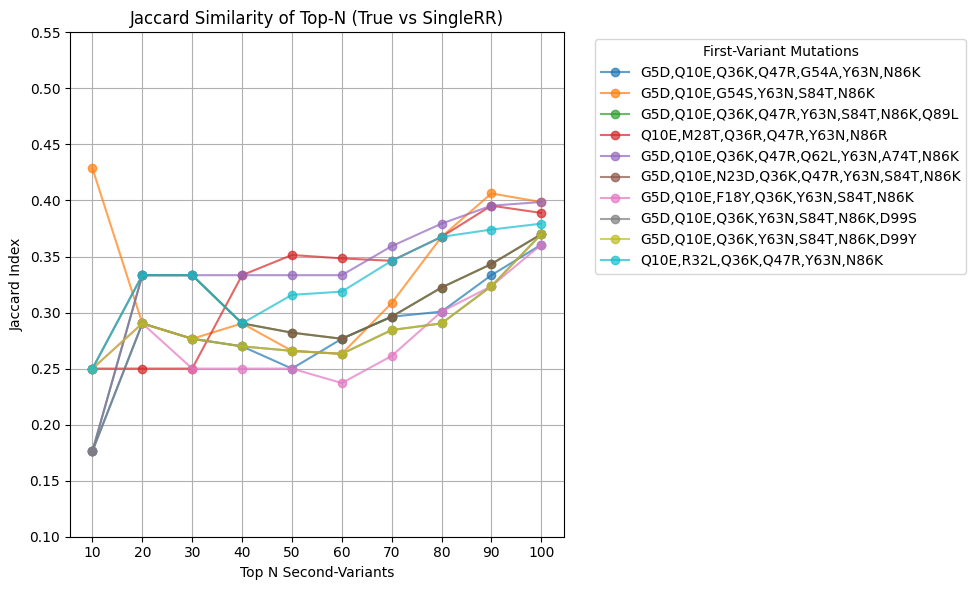

Saved plot to: /content/drive/MyDrive/Mid_1_RR_results/jaccard_vs_N_top10_mutations.png


In [4]:
# 1) Load test pairs and SingleRR predictions
df_te = pd.read_csv(
    '/content/drive/MyDrive/Mid_1_data_train/data_contrastive_test_r3.csv'
).copy()

test_single = pd.read_csv(
    '/content/drive/MyDrive/Mid_1_data_train/data_single_test_r3.csv'
)
single_preds = pickle.load(open(
    "/content/drive/MyDrive/Mid_1_RR_results/single_final_predictions.pkl", "rb"
))["preds"]
seq2fit = dict(zip(test_single['seq'], single_preds))

# compute SingleRR_pred
df_te['SingleRR_pred'] = df_te.apply(
    lambda r: seq2fit[r['seq_2']] - r['fitness_1'],
    axis=1
)

# 2) Select top 10 first‐variants (by fitness_1) with group size > 200
cands = (
    df_te[['seq_1','fitness_1']]
    .drop_duplicates()
    .sort_values('fitness_1', ascending=False)
)

firsts = []
for seq, fitness in zip(cands['seq_1'], cands['fitness_1']):
    grp_size = (df_te['seq_1']==seq).sum()
    if grp_size > 200:
        firsts.append(seq)
    if len(firsts) == 10:
        break

# 3) Prepare mutation strings for legend
ref_seq = (
    "MAGSGSPLAQQIKNTLTFIGQANAAGRMDEVRTLQQNLHPLWAEYFQQTEGSGGSPLAQQIQYGHVLIHQARAAGRMDEVRRLSENTLQLMKEYFQQSD"
)
mut_pattern = re.compile(r'.')
legend_labels = {}
for fv in firsts:
    muts = []
    for i, (r_aa, f_aa) in enumerate(zip(ref_seq, fv)):
        if r_aa != f_aa:
            muts.append(f"{r_aa}{i+1}{f_aa}")
    legend_labels[fv] = ",".join(muts) if muts else "WT"

# 4) Compute Jaccard indices
Ns = list(range(10, 101, 10))
jaccard_dict = {fv: [] for fv in firsts}

for fv in firsts:
    grp = df_te[df_te['seq_1']==fv]
    # sort second-variants
    true_rank = grp.sort_values('label', ascending=False)['seq_2'].tolist()
    single_rank = grp.sort_values('SingleRR_pred', ascending=False)['seq_2'].tolist()
    for N in Ns:
        set_true   = set(true_rank[:N])
        set_single = set(single_rank[:N])
        union = set_true | set_single
        j = len(set_true & set_single) / len(union) if union else np.nan
        jaccard_dict[fv].append(j)

# 5) Plot
plt.figure(figsize=(10,6))
for fv in firsts:
    plt.plot(
        Ns,
        jaccard_dict[fv],
        marker='o',
        alpha=0.7,
        label=legend_labels[fv]
    )
plt.xlabel("Top N Second‐Variants")
plt.ylabel("Jaccard Index")
plt.title("Jaccard Similarity of Top‐N (True vs SingleRR)")
plt.xticks(Ns)
plt.ylim(0.10, 0.55)
plt.yticks(np.arange(0.10, 0.55 + 1e-6, 0.05))
plt.legend(title="First‐Variant Mutations", bbox_to_anchor=(1.05,1), loc='upper left')
plt.grid(True)
plt.tight_layout()

out_path = "/content/drive/MyDrive/Mid_1_RR_results/jaccard_vs_N_top10_mutations.png"
plt.savefig(out_path)
plt.show()
print(f"Saved plot to: {out_path}")

# Top 10 first variants' Jaccard Index --- ground truth vs CNN_Contrastive

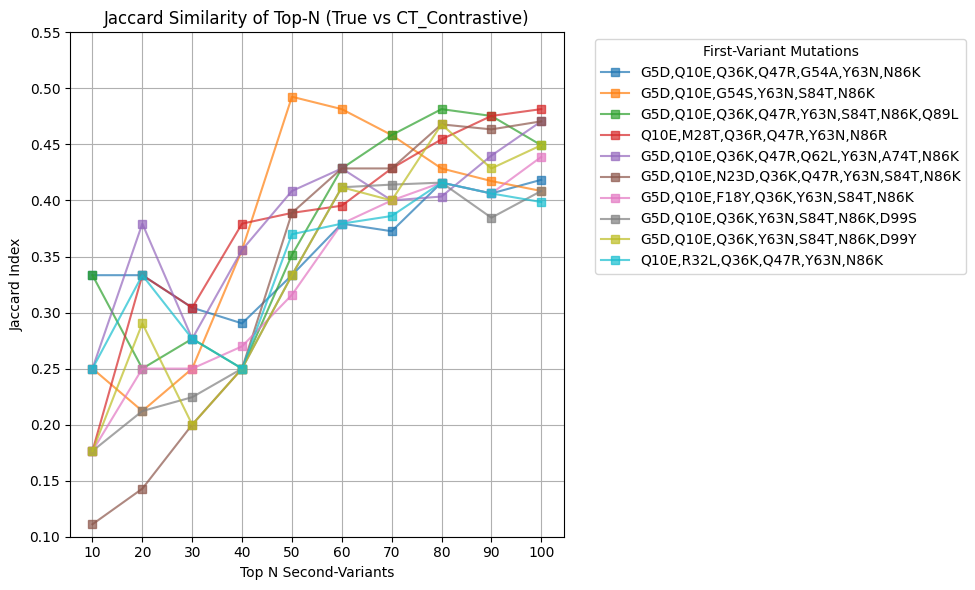

Saved plot to: /content/drive/MyDrive/Mid_1_RR_results/jaccard_vs_N_top10_contrastive.png


In [4]:
# 1) Load test pairs and Contrastive predictions
df_te = pd.read_csv(
    '/content/drive/MyDrive/Mid_1_data_train/data_contrastive_test_r3.csv'
).copy()

# Load Contrastive preds and attach
best_preds = pickle.load(open(
    "/content/drive/MyDrive/Mid_1_Contrast_results/CT_Contrastive_preds.pkl", "rb"
))['preds'][-len(df_te):]
df_te['Contrast_pred'] = best_preds



# 2) Select top 10 first‐variants (by fitness_1) with group size > 200
cands = (
    df_te[['seq_1','fitness_1']]
    .drop_duplicates()
    .sort_values('fitness_1', ascending=False)
)

firsts = []
for seq, fitness in zip(cands['seq_1'], cands['fitness_1']):
    grp_size = (df_te['seq_1']==seq).sum()
    if grp_size > 200:
        firsts.append(seq)
    if len(firsts) == 10:
        break


# 3) Prepare mutation strings for legend
ref_seq = (
    "MAGSGSPLAQQIKNTLTFIGQANAAGRMDEVRTLQQNLHPLWAEYFQQTEGSGGSPLAQQIQYGHVLIHQARAAGRMDEVRRLSENTLQLMKEYFQQSD"
)
legend_labels = {}
for fv in firsts:
    muts = []
    for i, (r_aa, f_aa) in enumerate(zip(ref_seq, fv)):
        if r_aa != f_aa:
            muts.append(f"{r_aa}{i+1}{f_aa}")
    legend_labels[fv] = ",".join(muts) if muts else "WT"

# 4) Compute Jaccard indices using Contrast_pred
Ns = list(range(10, 101, 10))
jaccard_dict = {fv: [] for fv in firsts}

for fv in firsts:
    grp = df_te[df_te['seq_1']==fv]
    true_rank     = grp.sort_values('label',          ascending=False)['seq_2'].tolist()
    contrast_rank = grp.sort_values('Contrast_pred',  ascending=False)['seq_2'].tolist()
    for N in Ns:
        set_true     = set(true_rank[:N])
        set_contrast = set(contrast_rank[:N])
        union = set_true | set_contrast
        j = len(set_true & set_contrast) / len(union) if union else np.nan
        jaccard_dict[fv].append(j)

# 5) Plot
plt.figure(figsize=(10,6))
for fv in firsts:
    plt.plot(
        Ns,
        jaccard_dict[fv],
        marker='s',
        alpha=0.7,
        label=legend_labels[fv]
    )
plt.xlabel("Top N Second‐Variants")
plt.ylabel("Jaccard Index")
plt.title("Jaccard Similarity of Top‐N (True vs CT_Contrastive)")
plt.xticks(Ns)
plt.ylim(0.10, 0.55)
plt.yticks(np.arange(0.10, 0.55 + 1e-6, 0.05))
plt.legend(title="First‐Variant Mutations", bbox_to_anchor=(1.05,1), loc='upper left')
plt.grid(True)
plt.tight_layout()

out_path = "/content/drive/MyDrive/Mid_1_RR_results/jaccard_vs_N_top10_contrastive.png"
plt.savefig(out_path)
plt.show()
print(f"Saved plot to: {out_path}")

# Top 100 **first** variants' Jaccard Index --- ground truth vs CT_Contrastive

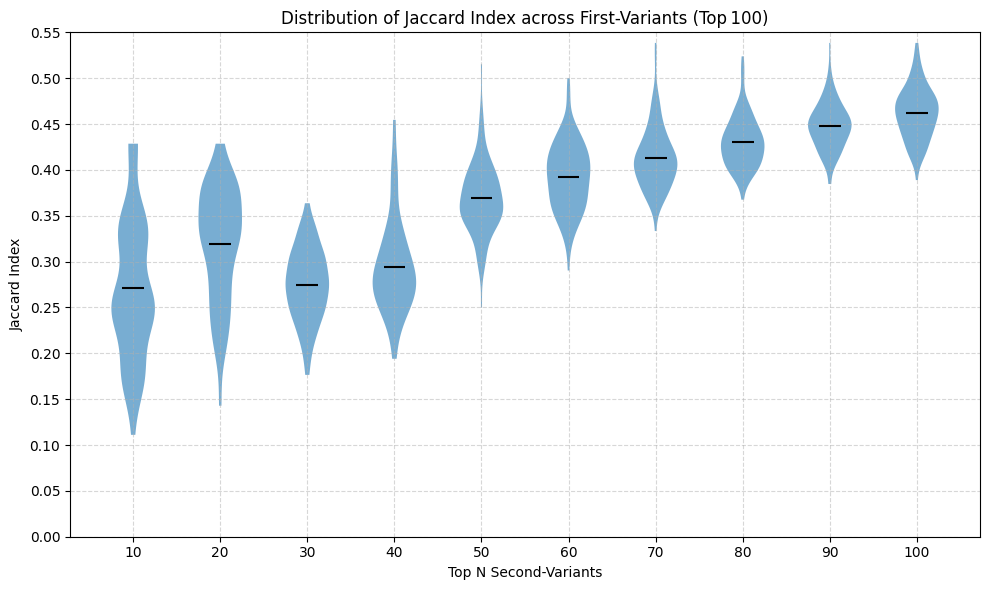

Saved violin plot to: /content/drive/MyDrive/Mid_1_RR_results/jaccard_vs_N_top100_contrastive_violin.png


In [9]:
# 1) Load test pairs and Contrastive predictions
df_te = pd.read_csv(
    '/content/drive/MyDrive/Mid_1_data_train/data_contrastive_test_r3.csv'
).copy()

# Load Contrastive preds and attach
best_preds = pickle.load(open(
    "/content/drive/MyDrive/Mid_1_Contrast_results/CNN_Contrastive_preds.pkl", "rb"
))['preds'][-len(df_te):]
df_te['Contrast_pred'] = best_preds


# 2) Select top 100 first‐variants (by fitness_1) with group size > 300
cands = (
    df_te[['seq_1','fitness_1']]
      .drop_duplicates()
      .sort_values('fitness_1', ascending=False)
)

firsts = []
for seq, fitness in zip(cands['seq_1'], cands['fitness_1']):
    if (df_te['seq_1'] == seq).sum() > 300:
        firsts.append(seq)
    if len(firsts) == 100:
        break


# 3) Compute Jaccard indices
Ns = list(range(10, 101, 10))
jaccard_dict = {fv: [] for fv in firsts}

for fv in firsts:
    grp = df_te[df_te['seq_1'] == fv]
    true_rank     = grp.sort_values('label',          ascending=False)['seq_2'].tolist()
    contrast_rank = grp.sort_values('Contrast_pred',  ascending=False)['seq_2'].tolist()
    for N in Ns:
        set_true     = set(true_rank[:N])
        set_contrast = set(contrast_rank[:N])
        union = set_true | set_contrast
        j = len(set_true & set_contrast) / len(union) if union else np.nan
        jaccard_dict[fv].append(j)

# 4) Prepare data for violin plot:
#    for each N, collect the 100 Jaccard values
violin_data = [
    [jaccard_dict[fv][i] for fv in firsts]
    for i in range(len(Ns))
]

# 5) Plot
plt.figure(figsize=(10,6))
parts = plt.violinplot(
    violin_data,
    positions=Ns,
    widths=5,
    showmeans=True,
    showextrema=False
)

# (Optional) Style the means
for pc in parts['bodies']:
    pc.set_alpha(0.6)
parts['cmeans'].set_color('k')
parts['cmeans'].set_linewidth(1.5)

plt.xlabel("Top N Second-Variants")
plt.ylabel("Jaccard Index")
plt.title("Distribution of Jaccard Index across First-Variants (Top 100)")
plt.xticks(Ns)
plt.ylim(0.10, 0.55)
plt.yticks(np.arange(0.00, 0.55 + 1e-6, 0.05))
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

out_path = "/content/drive/MyDrive/Mid_1_RR_results/jaccard_vs_N_top100_contrastive_violin.png"
plt.savefig(out_path)
plt.show()

print(f"Saved violin plot to: {out_path}")

# Top 100 **first** variants' Jaccard Index --- ground truth vs SingleRR

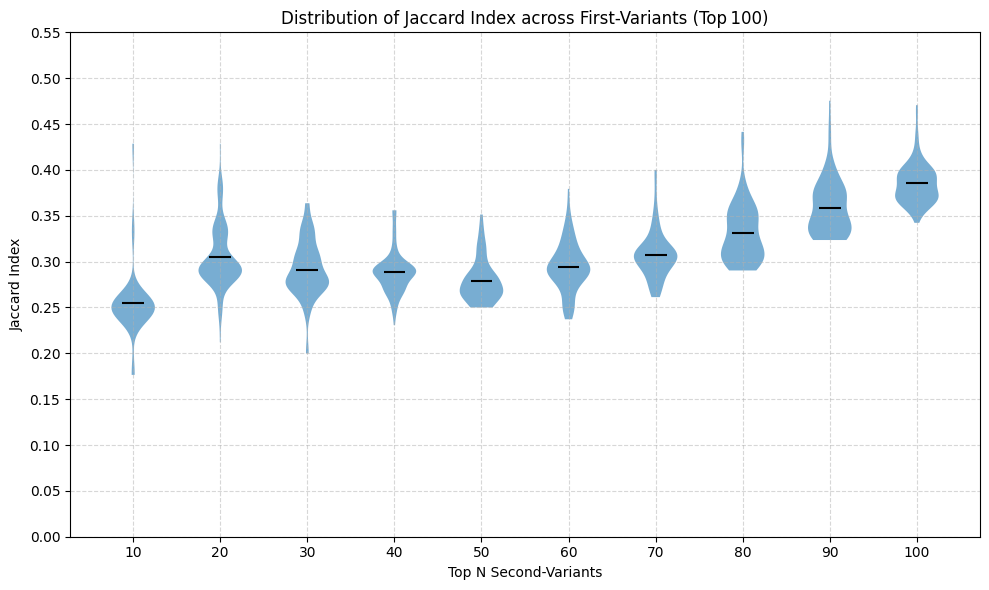

Saved violin plot to: /content/drive/MyDrive/Mid_1_RR_results/jaccard_vs_N_top100_single_violin.png


In [8]:
# 1) Load test pairs and SingleRR predictions
df_te = pd.read_csv(
    '/content/drive/MyDrive/Mid_1_data_train/data_contrastive_test_r3.csv'
).copy()

test_single = pd.read_csv(
    '/content/drive/MyDrive/Mid_1_data_train/data_single_test_r3.csv'
)
single_preds = pickle.load(open(
    "/content/drive/MyDrive/Mid_1_RR_results/single_final_predictions.pkl", "rb"
))["preds"]
seq2fit = dict(zip(test_single['seq'], single_preds))

# compute SingleRR_pred
df_te['SingleRR_pred'] = df_te.apply(
    lambda r: seq2fit[r['seq_2']] - r['fitness_1'],
    axis=1
)

# 2) Select top 100 first‐variants (by fitness_1) with group size > 300
cands = (
    df_te[['seq_1','fitness_1']]
      .drop_duplicates()
      .sort_values('fitness_1', ascending=False)
)

firsts = []
for seq, fitness in zip(cands['seq_1'], cands['fitness_1']):
    if (df_te['seq_1'] == seq).sum() > 300:
        firsts.append(seq)
    if len(firsts) == 100:
        break


# 3) Compute Jaccard indices
Ns = list(range(10, 101, 10))
jaccard_dict = {fv: [] for fv in firsts}

for fv in firsts:
    grp = df_te[df_te['seq_1']==fv]
    # sort second-variants
    true_rank = grp.sort_values('label', ascending=False)['seq_2'].tolist()
    single_rank = grp.sort_values('SingleRR_pred', ascending=False)['seq_2'].tolist()
    for N in Ns:
        set_true   = set(true_rank[:N])
        set_single = set(single_rank[:N])
        union = set_true | set_single
        j = len(set_true & set_single) / len(union) if union else np.nan
        jaccard_dict[fv].append(j)


# 4) Prepare data for violin plot:
#    for each N, collect the 100 Jaccard values
violin_data = [
    [jaccard_dict[fv][i] for fv in firsts]
    for i in range(len(Ns))
]

# 5) Plot
plt.figure(figsize=(10,6))
parts = plt.violinplot(
    violin_data,
    positions=Ns,
    widths=5,
    showmeans=True,
    showextrema=False
)

# (Optional) Style the means
for pc in parts['bodies']:
    pc.set_alpha(0.6)
parts['cmeans'].set_color('k')
parts['cmeans'].set_linewidth(1.5)

plt.xlabel("Top N Second-Variants")
plt.ylabel("Jaccard Index")
plt.title("Distribution of Jaccard Index across First-Variants (Top 100)")
plt.xticks(Ns)
plt.ylim(0.10, 0.55)
plt.yticks(np.arange(0.00, 0.55 + 1e-6, 0.05))
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

out_path = "/content/drive/MyDrive/Mid_1_RR_results/jaccard_vs_N_top100_single_violin.png"
plt.savefig(out_path)
plt.show()

print(f"Saved violin plot to: {out_path}")